In [3]:
source("../../src/utils/custom_tools.R")
setup_environment("../../src/utils")

Warning message:
“package ‘dplyr’ was built under R version 3.5.1”

In [61]:
impact <- read.table("../../data/annotated_final_IMPACT_mutations_180508.txt", sep = "\t", stringsAsFactors = FALSE, header = TRUE)

In [62]:
nrow(impact)

[1] 194211

In [63]:
print(colnames(impact))

 [1] "Hugo_Symbol"             "Chromosome"             
 [3] "Start_Position"          "End_Position"           
 [5] "Consequence"             "Variant_Type"           
 [7] "Reference_Allele"        "Tumor_Seq_Allele2"      
 [9] "Tumor_Sample_Barcode"    "cDNA_change"            
[11] "HGVSp_Short"             "t_depth"                
[13] "t_vaf"                   "t_alt_count"            
[15] "n_depth"                 "n_vaf"                  
[17] "n_alt_count"             "t_ref_plus_count"       
[19] "t_ref_neg_count"         "t_alt_plus_count"       
[21] "t_alt_neg_count"         "confidence_class"       
[23] "sample_coverage"         "mut_key"                
[25] "VAG_VT"                  "VAG_GENE"               
[27] "VAG_cDNA_CHANGE"         "VAG_PROTEIN_CHANGE"     
[29] "VAG_EFFECT"              "VEP_Consequence"        
[31] "VEP_SYMBOL"              "VEP_HGVSc"              
[33] "VEP_HGVSp"               "VEP_Amino_acids"        
[35] "VEP_VARIANT_CLASS"       

In [64]:
get_table(impact$confidence_class)
impact$class <- "somatic"
impact$class[impact$confidence_class == "UNLIKELY"] <- "non-somatic"
get_table(impact$class)

values,count,freq
AUTO_OK,180832,93.1%
UNLIKELY,7199,3.7%
MANUAL_OK,6180,3.2%
-- total --,194211,100%


values,count,freq
somatic,187012,96.3%
non-somatic,7199,3.7%
-- total --,194211,100%


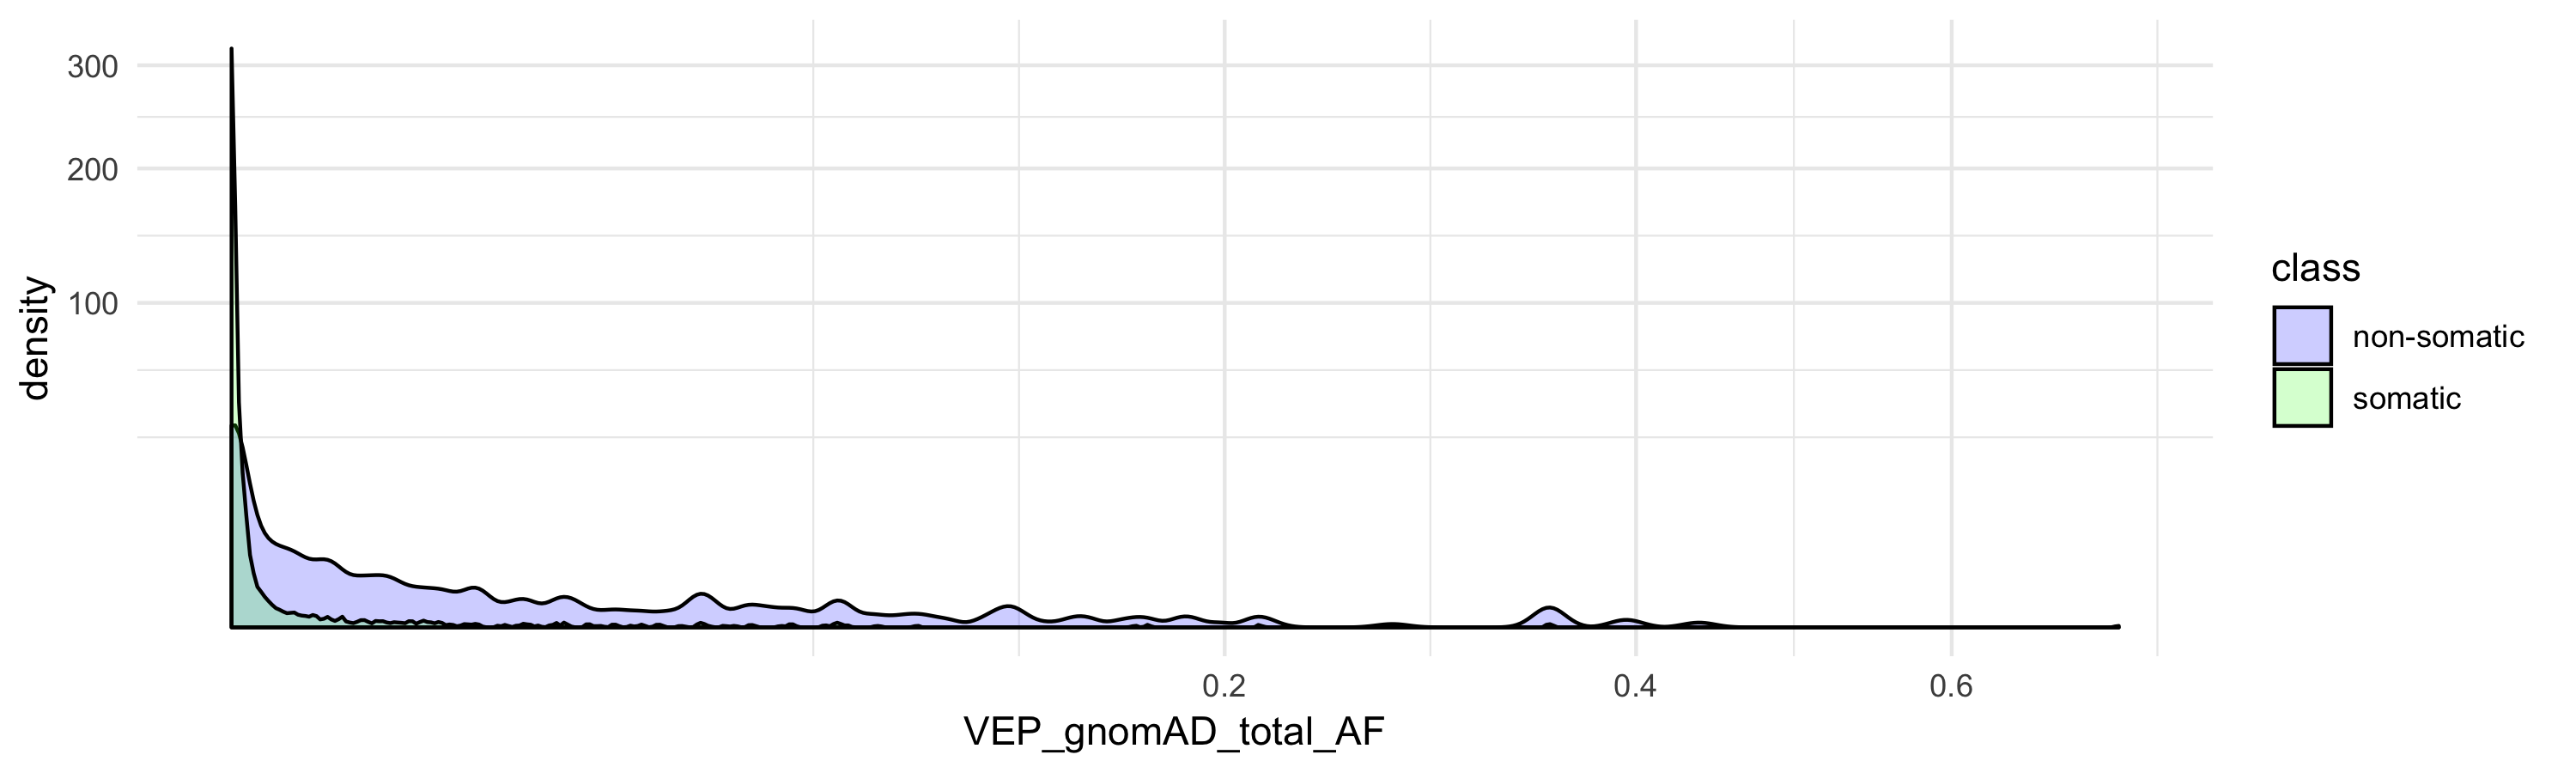

In [65]:
plot_density(impact, "VEP_gnomAD_total_AF", "class") + scale_y_sqrt() + scale_x_sqrt()

In [66]:
get_table(impact$oncogenic)
impact$is_driver <- "no"
impact$is_driver[impact$oncogenic %in% c("Oncogenic", "Likely Oncogenic", "Predicted Oncogenic")] <- "yes"
impact$is_driver[impact$is_somatic] <- "na"
get_table(impact$is_driver)

values,count,freq
Unknown,128358,66.1%
Likely Oncogenic,48011,24.7%
Oncogenic,14247,7.3%
Predicted Oncogenic,2715,1.4%
Inconclusive,504,0.3%
Likely Neutral,376,0.2%
-- total --,194211,100%


values,count,freq
no,129238,66.5%
yes,64973,33.5%
-- total --,194211,100%


In [68]:
get_table(impact$VEP_Consequence)

values,count,freq
missense_variant,139761,72%
frameshift_variant,23810,12.3%
stop_gained,18094,9.3%
inframe_deletion,3980,2%
splice_acceptor_variant,3950,2%
splice_donor_variant,3175,1.6%
inframe_insertion,876,0.5%
start_lost,354,0.2%
stop_lost,211,0.1%
-- total --,194211,100%


In [70]:
get_table(impact$is_driver[impact$class == "non-somatic"])

values,count,freq
no,5909,82.1%
yes,1290,17.9%
-- total --,7199,100%


In [72]:
get_table(impact$is_driver[impact$class == "non-somatic"])
nrow(impact %>% filter(class == "non-somatic" & mut_key %in% impact$mut_key[impact$class == "somatic"]))
nrow(impact %>% filter(class == "non-somatic" &
                       mut_key %in% impact$mut_key[impact$class == "somatic"] &
                       is_driver == "yes"))

values,count,freq
no,5909,82.1%
yes,1290,17.9%
-- total --,7199,100%


[1] 2354

[1] 560

In [49]:
unique(impact$VEP_SIFT_score[impact$VEP_Consequence == "stop_lost"])

[1] NA

In [10]:
length(unique(impact$patient_key))

[1] 21032

In [11]:
length(unique(impact$Tumor_Sample_Barcode))

[1] 22747

We need to study the reccurence of mutations taking care not to consider a mutation as recurrent if it comes frome the same patient. To do so we will group the rows by patient, and select only the distinct mutations for each patient:

In [136]:
impact_unique_mut_keys_per_patient <- as.data.frame(impact %>% group_by(patient_key) %>%
                                                               select(patient_key, mut_key, VEP_SYMBOL, is_driver, VEP_HGVSp) %>%
                                                               filter(! duplicated(mut_key)))
nrow(impact)
nrow(impact_unique_mut_keys_per_patient)

[1] 194211

[1] 186637

In [137]:
mut_key_info <- as.data.frame(impact_unique_mut_keys_per_patient %>% group_by(mut_key) %>%
                                                                     summarise(reccurence_in_dataset = n(), VEP_SYMBOL = unique(VEP_SYMBOL), is_driver = unique(is_driver), VEP_HGVSp = unique(VEP_HGVSp)))
head(mut_key_info)

mut_key,reccurence_in_dataset,VEP_SYMBOL,is_driver,VEP_HGVSp
1_11167549_A_G,1,MTOR,no,p.F2548S
1_11168271_G_A,1,MTOR,no,p.S2534F
1_11168272_A_G,1,MTOR,no,p.S2534P
1_11168304_G_A,1,MTOR,no,p.T2523M
1_11168316_A_G,1,MTOR,no,p.L2519S
1_11168326_C_T,1,MTOR,no,p.D2516N


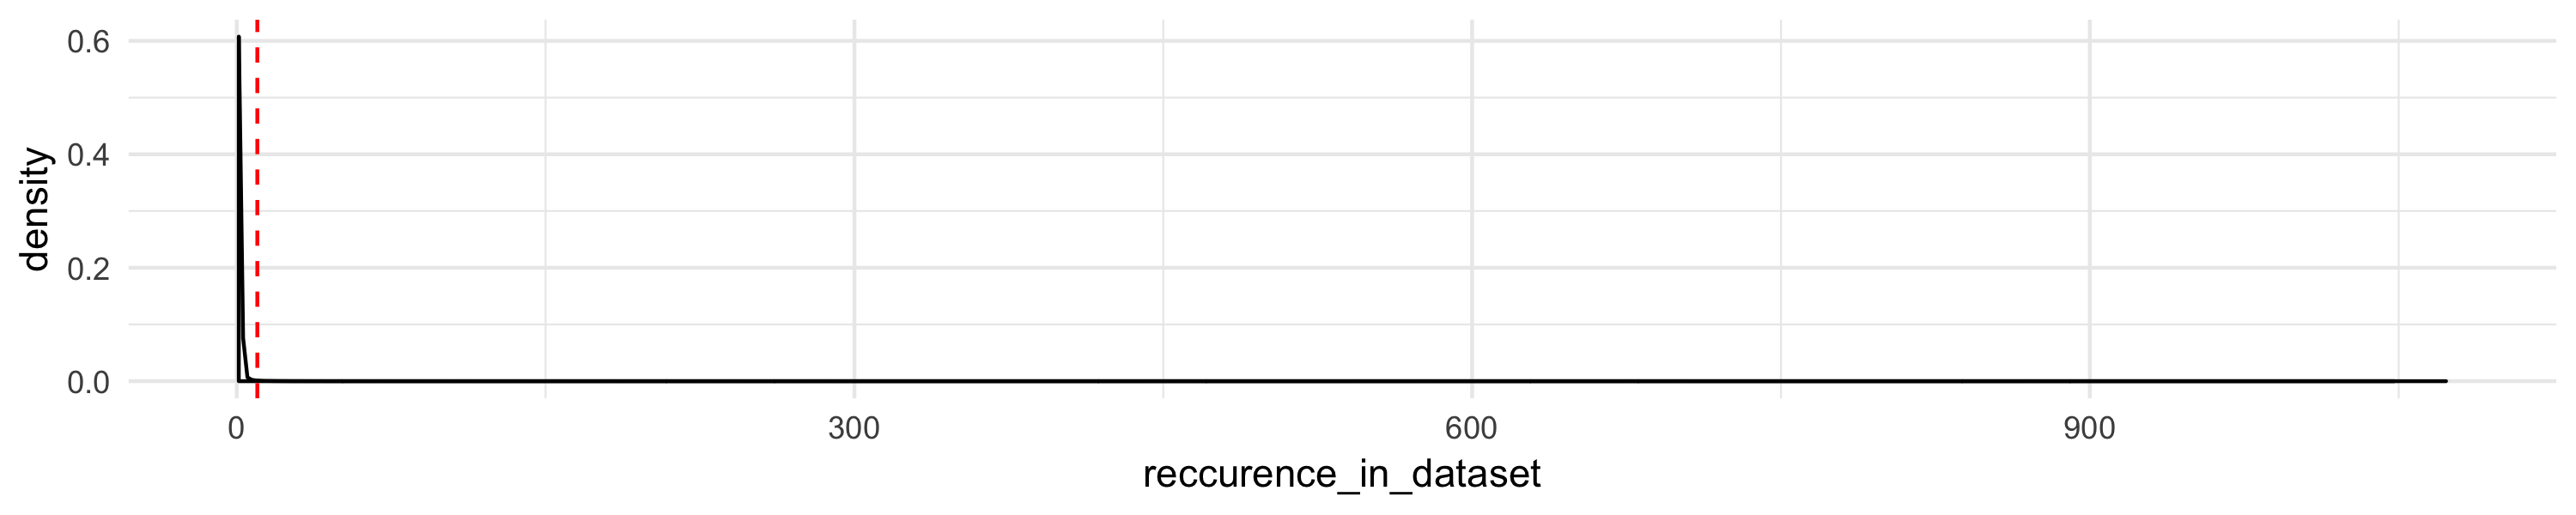

In [89]:
repeated_key <- mut_key_info[mut_key_info$reccurence_in_dataset >= 2,] # keys shared by at least 2 samples
plot_density(mut_key_info, "reccurence_in_dataset", adjust = 1, lines = 10, height = 2)

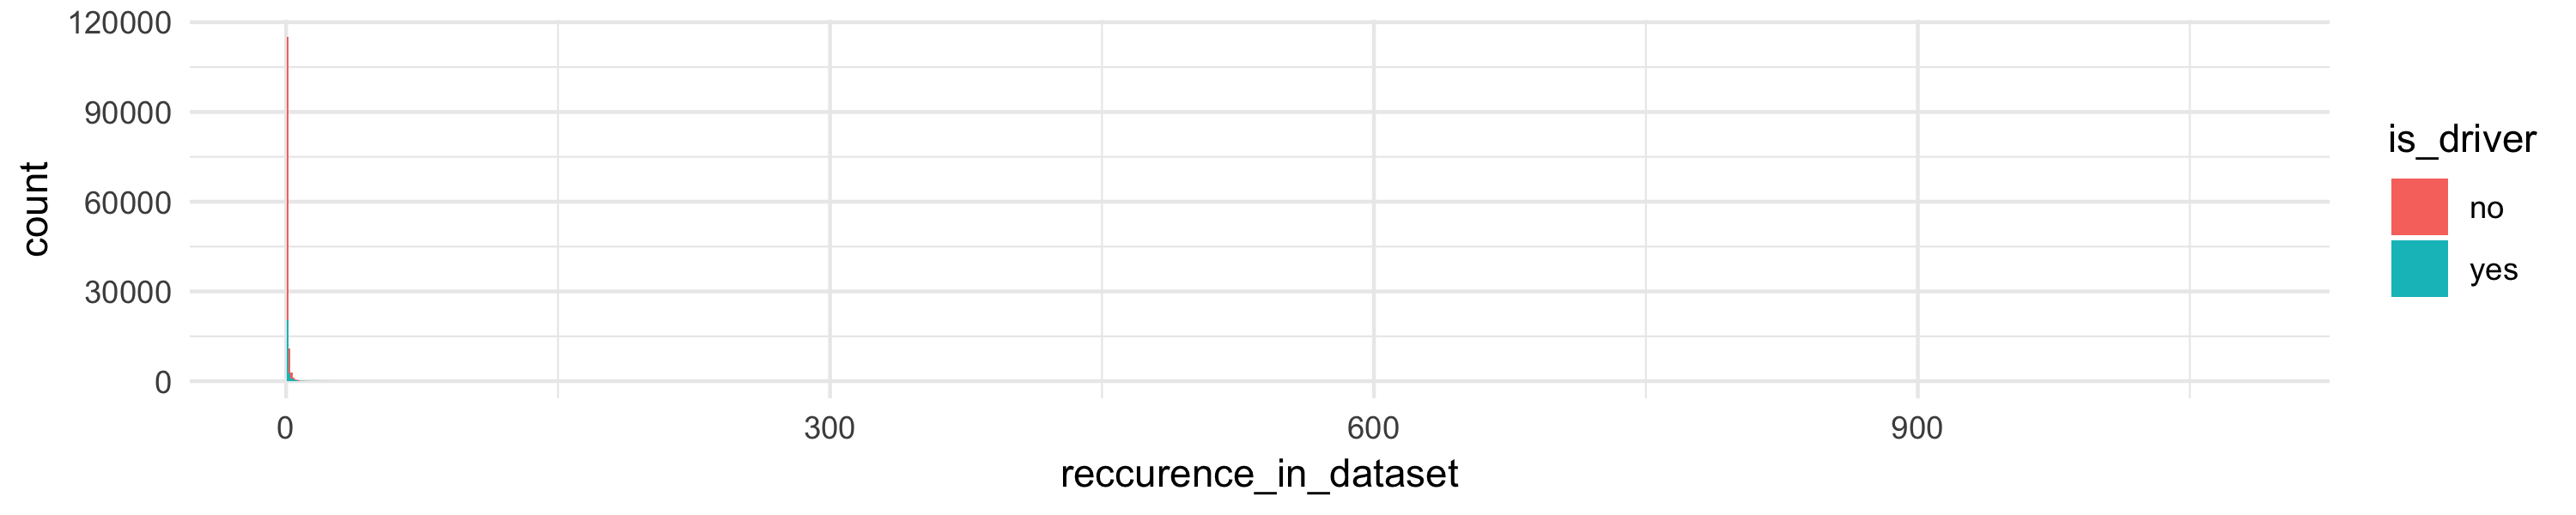

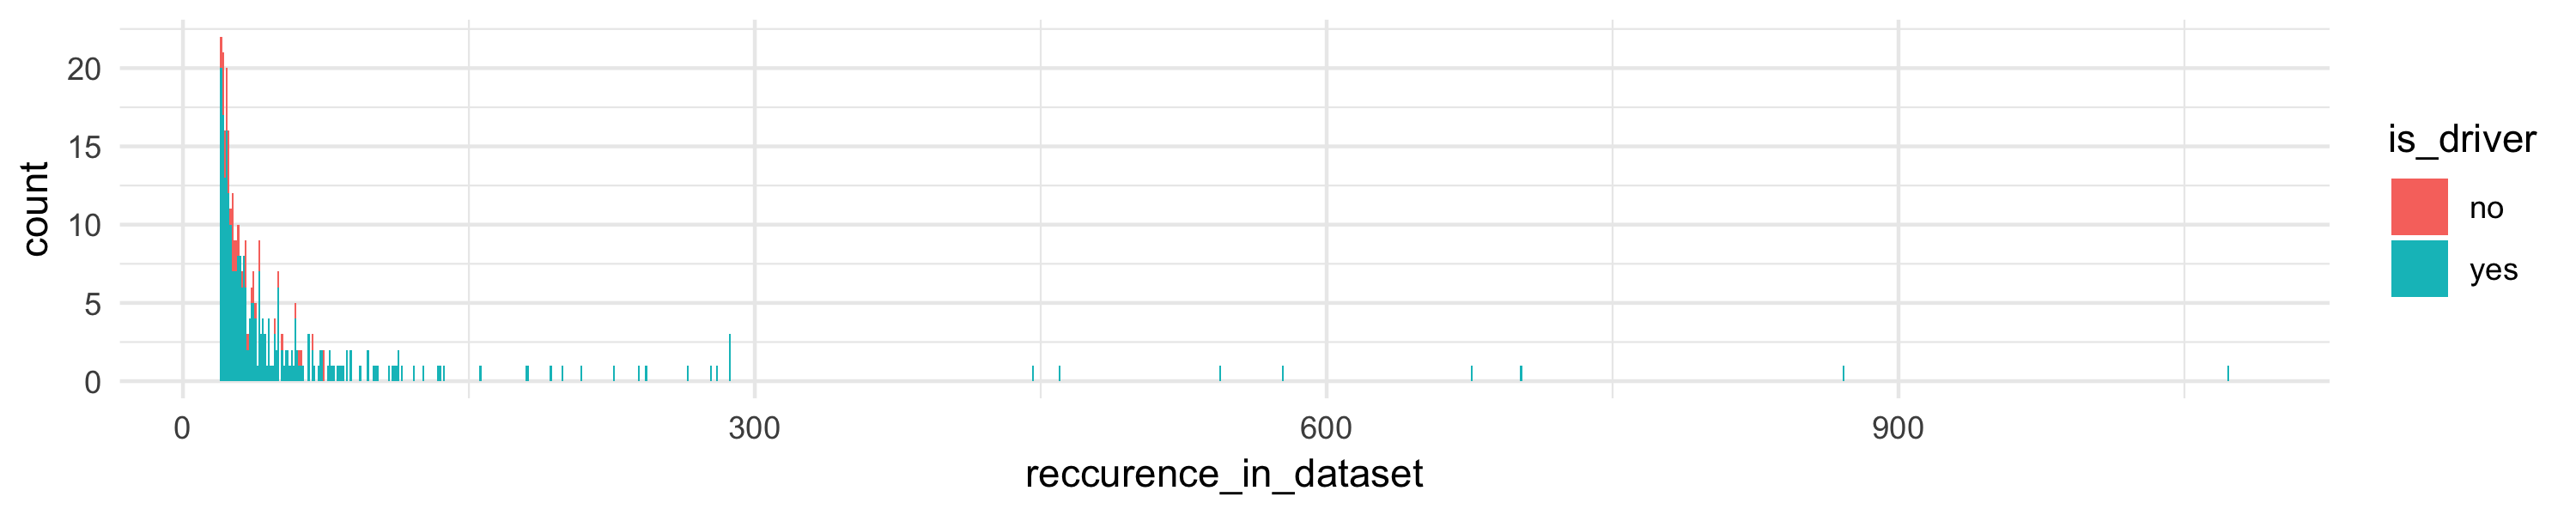

In [122]:
ggplot(mut_key_info) + geom_histogram(aes(reccurence_in_dataset, fill = is_driver), binwidth = 1)
ggplot(mut_key_info[mut_key_info$reccurence_in_dataset >= 20,]) + geom_histogram(aes(reccurence_in_dataset, fill = is_driver), binwidth = 1)

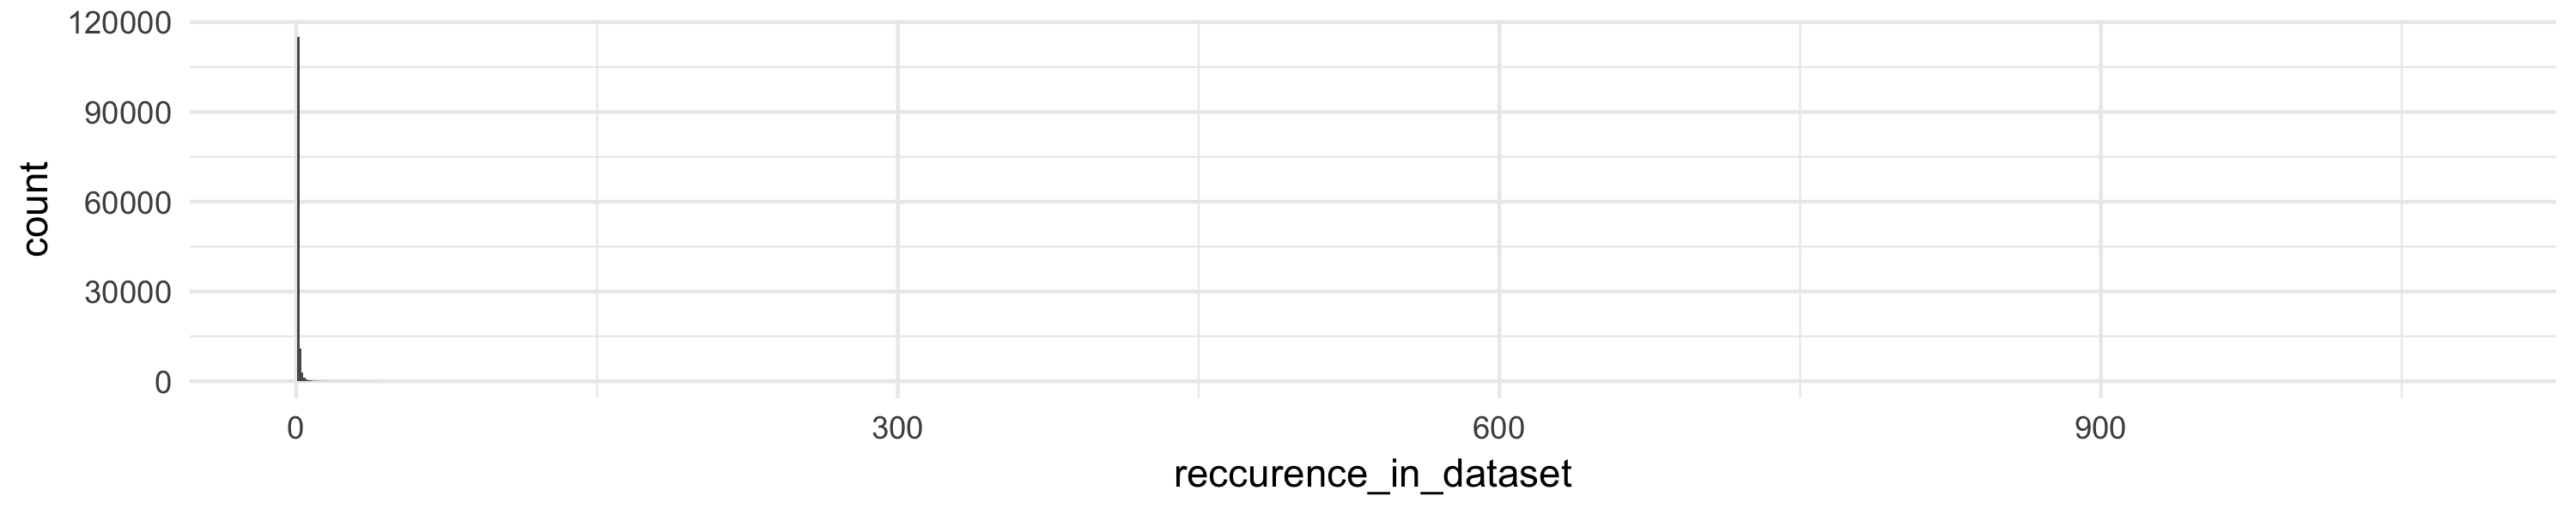

In [111]:
ggplot(mut_key_info) + geom_histogram(aes(reccurence_in_dataset), binwidth = 1)

In [138]:
mut_key_info[mut_key_info$reccurence_in_dataset >= 300,]

,mut_key,reccurence_in_dataset,VEP_SYMBOL,is_driver,VEP_HGVSp
22597,12_25398284_C_A,871,KRAS,yes,p.G12V
22599,12_25398284_C_T,1073,KRAS,yes,p.G12D
22604,12_25398285_C_A,544,KRAS,yes,p.G12C
53738,17_7578406_C_T,460,TP53,yes,p.R175H
82580,3_178936082_G_A,446,PIK3CA,yes,p.E542K
82586,3_178936091_G_A,676,PIK3CA,yes,p.E545K
82738,3_178952085_A_G,702,PIK3CA,yes,p.H1047R
111691,7_140453136_A_T,577,BRAF,yes,p.V600E


In [91]:
for (threshold in c(2, 3, 5, 10)) {
    
    mut_key_info_threshold <- mut_key_info[mut_key_info$reccurence_in_dataset >= threshold,]
    
    print(sprintf("%2.0f%% (%5d) of the keys are shared by at least %2d samples [%2.0f%% (%5d) of the rows concerned]",
                  100 * nrow(mut_key_info_threshold) / nrow(mut_key_info),
                  nrow(mut_key_info_threshold),
                  threshold,
                  100 * nrow(impact_unique_mut_keys_per_patient[impact_unique_mut_keys_per_patient$mut_key %in% mut_key_info_threshold$mut_key,]) / nrow(impact_unique_mut_keys_per_patient),
                  nrow(impact_unique_mut_keys_per_patient[impact_unique_mut_keys_per_patient$mut_key %in% mut_key_info_threshold$mut_key,])))
}

[1] "13% (17158) of the keys are shared by at least  2 samples [38% (71520) of the rows concerned]"
[1] " 5% ( 6120) of the keys are shared by at least  3 samples [26% (49444) of the rows concerned]"
[1] " 2% ( 2192) of the keys are shared by at least  5 samples [20% (36556) of the rows concerned]"
[1] " 1% (  834) of the keys are shared by at least 10 samples [15% (28114) of the rows concerned]"


In [130]:
mut_key_info <- mut_key_info[mut_key_info$is_driver == "yes",]

for (threshold in c(2, 3, 5, 10, 300)) {
    
    mut_key_info_threshold <- mut_key_info[mut_key_info$reccurence_in_dataset >= threshold,]
    
    print(sprintf("%2.0f%% (%5d) of the keys are shared by at least %2d samples [%2.0f%% (%5d) of the rows concerned]",
                  100 * nrow(mut_key_info_threshold) / nrow(mut_key_info),
                  nrow(mut_key_info_threshold),
                  threshold,
                  100 * nrow(impact_unique_mut_keys_per_patient[impact_unique_mut_keys_per_patient$mut_key %in% mut_key_info_threshold$mut_key,]) / nrow(impact_unique_mut_keys_per_patient),
                  nrow(impact_unique_mut_keys_per_patient[impact_unique_mut_keys_per_patient$mut_key %in% mut_key_info_threshold$mut_key,])))
}

[1] "22% ( 5812) of the keys are shared by at least  2 samples [22% (41414) of the rows concerned]"
[1] "12% ( 3118) of the keys are shared by at least  3 samples [19% (36026) of the rows concerned]"
[1] " 6% ( 1583) of the keys are shared by at least  5 samples [17% (30889) of the rows concerned]"
[1] " 3% (  685) of the keys are shared by at least 10 samples [13% (25193) of the rows concerned]"
[1] " 0% (    8) of the keys are shared by at least 300 samples [ 3% ( 5349) of the rows concerned]"


Distribution of the mutations key count for the mutations present in at least 2 samples:

In [12]:
impact_original <- read.table("../../data/all_IMPACT_mutations_180508.txt", sep = "\t", stringsAsFactors = FALSE, header = TRUE)

In [18]:
get_table(impact_original$confidence_class)

values,count,freq
UNKNOWN,374531,63.6%
AUTO_OK,191228,32.5%
UNLIKELY,15317,2.6%
MANUAL_OK,7113,1.2%
OK_NOT_SO,358,0.1%
-- total --,588547,100%


In [20]:
nrow(impact_original)
impact_original$patient_key <- substr(impact_original$Tumor_Sample_Barcode, 1, 9)

[1] 588547

In [22]:
length(unique(impact_original$patient_key))

[1] 23162

In [14]:
impact_cleaned <- read.table("../../data/cleaned_IMPACT_mutations_180508.txt", sep = "\t", stringsAsFactors = FALSE, header = TRUE)

In [23]:
get_table(impact_cleaned$confidence_class)

values,count,freq
AUTO_OK,180733,72.8%
UNKNOWN,50034,20.2%
UNLIKELY,10846,4.4%
MANUAL_OK,6335,2.6%
OK_NOT_SO,345,0.1%
-- total --,248293,100%


In [16]:
get_table(impact$confidence_class)

values,count,freq
AUTO_OK,180832,93.1%
UNLIKELY,7199,3.7%
MANUAL_OK,6180,3.2%
-- total --,194211,100%
